# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de confusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape

(5000, 400)

In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y[Y == 10] = 0
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

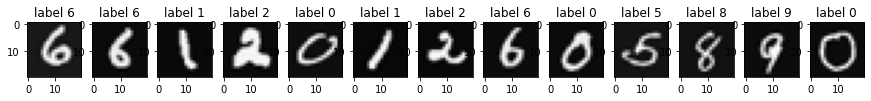

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion

In [6]:
def confusion_matrix(y_true, y_pred):
    #On obtient les classes distinctes et leurs nombres
    y_true_no_duplicate = sorted(set(y_true))
    n = len(y_true_no_duplicate)
    #On intialise la matricde de confusion
    matrix = np.zeros((n,n), dtype=np.int32)
    
    for i in range(len(y_true)):
        matrix[y_true_no_duplicate.index(y_true[i])][y_true_no_duplicate.index(y_pred[i])] += 1
    
    return matrix

- Rappel


In [7]:
def Recall(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tp = 0
    fn = 0
    recall = []
    for i in range(Nbr):
        tp = mat[i][i]
        fn = mat[(i+1):,i].sum() + mat[:i,i].sum()
        recall.append(0 if (tp+fn) == 0 else (tp/(tp+fn)))
    return recall[0] if Nbr == 2 else recall

- Précision

In [8]:
def Precision(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tp = 0
    fp = 0
    precision = []
    for i in range(Nbr):
        tp = mat[i][i]
        fp = mat[i,(i+1):].sum() + mat[i,:i].sum()
        precision.append(0 if (tp+fp) == 0 else (tp/(tp+fp)))
    return precision[0] if Nbr == 2 else precision

- Taux de FP

In [9]:
def FPR(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tp = 0
    fp = 0
    fpr = []
    for i in range(Nbr):
        tp = mat[i][i]
        fp = mat[i,(i+1):].sum() + mat[i,:i].sum()
        fpr.append(0 if (tp+fp) == 0 else (fp/(tp+fp)))
    return fpr[0] if Nbr == 2 else fpr

- Spécificité

In [10]:
def Specificity(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tn = 0
    fp = 0
    specificity = []
    for i in range(Nbr):
        tp = mat[:i,:i].sum() + mat[(i+1):,:i].sum() + mat[:i,(i+1):].sum() + mat[(i+1):,(i+1):].sum()
        fp = mat[i,(i+1):].sum() + mat[i,:i].sum()
        specificity.append(0 if (tp+fp) == 0 else (tp/(tp+fp)))
    return specificity[0] if Nbr == 2 else specificity

- Courbe ROC

In [11]:
def ROC(y_true,y_pred,y_score,thresholds):
    y_true_no_duplicate = sorted(set(y_true))
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    All_roc = []
    roc = []
    for y in y_true_no_duplicate:
        indices = [i for i, x in enumerate(y_true) if x == y]
        for threshold in thresholds:
            for i in indices: 
                if(y_score[i][y_pred[i]] >= threshold):
                    if(y_true[i] == y_pred[i]):
                        tp += 1
                    else:
                        fp += 1
                elif(y_score[i][y_pred[i]] < threshold):
                    if(y_true[i] == y_pred[i]):
                        tn += 1
                    else:
                        fn += 1
            tpr = 0 if (tp+fp) == 0 else (tp/(tp+fp))
            fpr = 0 if (tn+fp) == 0 else (fp/(tn+fp))
            roc.append([fpr,tpr])
        fpr_array = []
        tpr_array = []
        for i in range(len(roc)-1):
            point1 = roc[i]
            point2 = roc[i+1]
            tpr_array.append([point1[0], point2[0]])
            fpr_array.append([point1[1], point2[1]])
        All_roc.append([tpr_array,fpr_array])
    
    colors = ['blue', 'yellow', 'black', 'olive', 'green', 'pink', 'orange', 'brown', 'purple', 'red']
    i = 0
    for ar in All_roc:
        plt.plot(ar[0][0],ar[0][1], color = colors[i])
        i += 1
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All ROC Curves')
    plt.show()

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [12]:
tRatio=2/3
ttRatio=1/3
Xt, Xtt, Yt, Ytt = train_test_split(X,Y,test_size=ttRatio, train_size=tRatio)
print(Xt.shape,Xtt.shape,Yt.shape,Ytt.shape)

(3333, 400) (1667, 400) (3333,) (1667,)


# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [13]:
def minkowski_distance(a, b, p):
    
    dim = len(a)
    
    distance = 0
    
    for d in range(dim):
        distance += abs(a[d] - b[d])**p
        
    distance = distance**(1/p)
    
    return distance

In [14]:
def KPP(x, X, Y, Neighbors, distance):
    y_pred = []
    for a in x:
        distances = []
        for b in X:
            distances.append(minkowski_distance(a,b,distance))
        distances_sorted = distances.copy()
        distances_sorted.sort()
        distances_sorted = distances_sorted[:Neighbors]
        Closer_Points_Indexex = [i for i in range(len(distances)) if distances[i] in distances_sorted]
        Closer_Points_Classes = [Y[i] for i in Closer_Points_Indexex]
        y_pred.append(max(set(Closer_Points_Classes), key = Closer_Points_Classes.count))
    return np.array(y_pred, dtype=int)

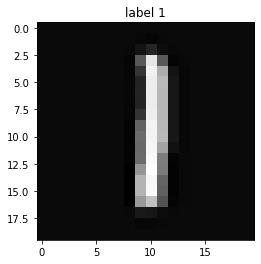

In [16]:
# tester une image
c= 69
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [18]:
y_pred = KPP(Xtt[:100], Xt, Yt, 5, 2)

print("Matrice de Confusion :")
print(confusion_matrix(Ytt[:100], y_pred[:100]))

print("Rappel :")
print(Recall(Ytt[:100], y_pred[:100]))

print("Precision :")
print(Precision(Ytt[:100], y_pred[:100]))

print("Taux de FP :")
print(FPR(Ytt[:100], y_pred[:100]))

print("Specificite :")
print(Specificity(Ytt[:100], y_pred[:100]))

Matrice de Confusion :
[[12  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  1]
 [ 0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  1]
 [ 0  0  0  0  1  9  0  0  0  0]
 [ 0  1  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 14]]
Rappel :
[1.0, 0.9230769230769231, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.875]
Precision :
[1.0, 1.0, 0.9166666666666666, 1.0, 0.8571428571428571, 0.9, 0.8888888888888888, 1.0, 1.0, 1.0]
Taux de FP :
[0.0, 0.0, 0.08333333333333333, 0.0, 0.14285714285714285, 0.1, 0.1111111111111111, 0.0, 0.0, 0.0]
Specificite :
[1.0, 1.0, 0.9887640449438202, 1.0, 0.989247311827957, 0.989010989010989, 0.9891304347826086, 1.0, 1.0, 1.0]


# Méthode 1: MVS
Machine à Vecteurs de Support

In [19]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

In [20]:
print("Matrice de Confusion :")
print(confusion_matrix(Ytt, y_pred))

print("Rappel :")
print(Recall(Ytt, y_pred))

print("Precision :")
print(Precision(Ytt, y_pred))

print("Taux de FP :")
print(FPR(Ytt, y_pred))

print("Specificite :")
print(Specificity(Ytt, y_pred))

Matrice de Confusion :
[[151   0   2   0   0   0   1   0   0   0]
 [  0 162   1   1   1   2   0   0   1   0]
 [  2   0 170   4   6   1   2   3   2   0]
 [  0   1   2 140   0   4   0   1   4   2]
 [  1   2   0   0 151   0   1   2   1   5]
 [  1   1   3  12   1 148   2   0   2   0]
 [  2   0   3   0   2   2 147   0   2   0]
 [  1   1   3   2   4   2   1 151   0   5]
 [  0   0   4   7   2  11   2   0 154   1]
 [  0   1   1   1   2   1   0   4   1 148]]
Rappel :
[0.9556962025316456, 0.9642857142857143, 0.8994708994708994, 0.8383233532934131, 0.893491124260355, 0.8654970760233918, 0.9423076923076923, 0.937888198757764, 0.9221556886227545, 0.9192546583850931]
Precision :
[0.9805194805194806, 0.9642857142857143, 0.8947368421052632, 0.9090909090909091, 0.9263803680981595, 0.8705882352941177, 0.930379746835443, 0.888235294117647, 0.850828729281768, 0.9308176100628931]
Taux de FP :
[0.01948051948051948, 0.03571428571428571, 0.10526315789473684, 0.09090909090909091, 0.0736196319018405, 0.12941176

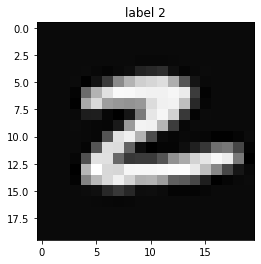

In [21]:
# tester une image
c= 45
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [22]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

In [23]:
print("Matrice de Confusion :")
print(confusion_matrix(Ytt, y_pred))

print("Rappel :")
print(Recall(Ytt, y_pred))

print("Precision :")
print(Precision(Ytt, y_pred))

print("Taux de FP :")
print(FPR(Ytt, y_pred))

print("Specificite :")
print(Specificity(Ytt, y_pred))

Matrice de Confusion :
[[140   0   2   3   0   4   2   0   3   0]
 [  0 135   8   2   6   3   2   2   9   1]
 [  8   7 121  18   6   8   4   6   9   3]
 [  1   0  10 103   1  13   2   3  14   7]
 [  0   2   3   4 128   3   3   4   2  14]
 [  3   3   8  26   3 110   6   4   2   5]
 [  2   2   1   5   6  10 128   1   3   0]
 [  4   3   6   3   4   2   1 131   1  15]
 [  7   7   3  10   2   9   9   4 126   4]
 [  2   0   6   5   6   8   0   6   6 120]]
Rappel :
[0.8383233532934131, 0.8490566037735849, 0.7202380952380952, 0.5754189944134078, 0.7901234567901234, 0.6470588235294118, 0.8152866242038217, 0.8136645962732919, 0.72, 0.7100591715976331]
Precision :
[0.9090909090909091, 0.8035714285714286, 0.6368421052631579, 0.6688311688311688, 0.7852760736196319, 0.6470588235294118, 0.810126582278481, 0.7705882352941177, 0.6961325966850829, 0.7547169811320755]
Taux de FP :
[0.09090909090909091, 0.19642857142857142, 0.3631578947368421, 0.33116883116883117, 0.2147239263803681, 0.35294117647058826, 

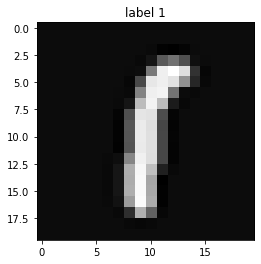

In [24]:
# tester une image
c= 3
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [25]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

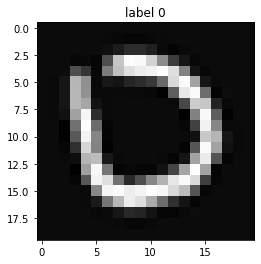

In [26]:
# Choisir un image de test 
c=0
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [27]:
y_pred = np.array(model.predict(Xtt), dtype=int)
y_pred

array([0, 7, 7, ..., 7, 0, 1])

In [28]:
print("Matrice de Confusion :")
print(confusion_matrix(Ytt, y_pred))

print("Rappel :")
print(Recall(Ytt, y_pred))

print("Precision :")
print(Precision(Ytt, y_pred))

print("Taux de FP :")
print(FPR(Ytt, y_pred))

print("Specificite :")
print(Specificity(Ytt, y_pred))

Matrice de Confusion :
[[330   2   1   3   0   2   0  16   0   0]
 [  0 198  12   0   0   0 112  29   0   0]
 [ 16  26   8   2   0   2  13 287   0   0]
 [  3   2   0  80   0  78   1 194   0   0]
 [  1   9   6   1   0   0   2 319   0   0]
 [  6   0   0  39   0 257   3  44   2   0]
 [  5  36   1   1   0  10 280  10   0   0]
 [  3   4   2   2   0   0   0 339   0   0]
 [  1  19   4  15   0   4   9 298   0   0]
 [  7   1   1   6   0   2   0 334   0   0]]
Rappel :
[0.8870967741935484, 0.6666666666666666, 0.22857142857142856, 0.5369127516778524, 0, 0.723943661971831, 0.6666666666666666, 0.18128342245989304, 0.0, 0]
Precision :
[0.9322033898305084, 0.5641025641025641, 0.022598870056497175, 0.22346368715083798, 0.0, 0.7321937321937322, 0.8163265306122449, 0.9685714285714285, 0.0, 0.0]
Taux de FP :
[0.06779661016949153, 0.4358974358974359, 0.9774011299435028, 0.776536312849162, 1.0, 0.2678062678062678, 0.1836734693877551, 0.03142857142857143, 1.0, 1.0]
Specificite :
[0.9923273657289002, 0.952232

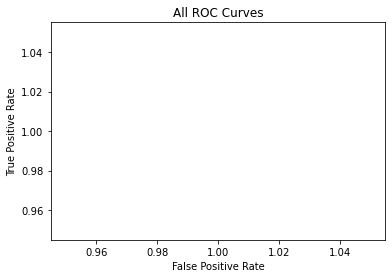

In [29]:
# pour ROC, il faudra les probabilités:
y_score = model.predict_proba(Xtt)
thresholds = [0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1]
ROC(Ytt, y_pred, y_score, thresholds)

Afficher l'image testée

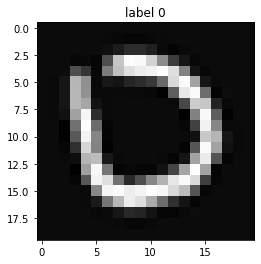

In [30]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [131]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [132]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)

y_pred = np.array(model.predict(Xtt_rncN), dtype=int)


# Appliquer les métriques implementées pour voir le résultat

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 4 Mars 2022 à 22h

La partie RNC peut être laissée pour le prochain TP

In [ ]:
# bonne chance